In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/101_ObjectCategories.tar.gz" "101_ObjectCategories.tar.gz" 

## Extracting all the data

In [0]:
import tarfile
with tarfile.open('/content/101_ObjectCategories.tar.gz', 'r:gz') as tar:
    tar.extractall()

## Importing Libraries

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
#from lshash import LSHash

## Loading and Preprocessing of Data

In [0]:
def preprocess_img(img_path):
  dsize = (299,299)
  new_image=cv2.imread(img_path)
  new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
  new_image=np.expand_dims(new_image,axis=0)
  new_image=preprocess_input(new_image)
  return new_image

def load_data():
    output = []
    pp=[]
    directory = "/content/101_ObjectCategories" 
    categories=sorted(os.listdir(directory))
    for files in sorted(os.listdir(directory)):
      for file in files:
      img_path=directory+"/"+files+"/"+file
      output.append(img_path)
    return output

## Defining model and extracting feature for all the training data.

In [0]:
def model():
  model=Xception(weights='imagenet',include_top=False)
  for layer in model.layers:
    layer.trainable=False
  #model.summary()
  return model

def feature_extraction(image_data,model):
  features=model.predict(image_data)
  features=np.array(features)
  features=features.flatten()
  return features

## Finding the similar image through LSH and cosine similarity.


In [183]:
def result_vector_cosine(model,feature_vector,new_img):
  new_feature = model.predict(new_img)
  new_feature = np.array(new_feature)
  new_feature = new_feature.flatten()
  N_result = 6
  nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
  distances, indices = nbrs.kneighbors([new_feature])
  return(indices)

#LSH code taken from https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5
def result_vector_lsh(img_path,feature_vec,new_img):
  k = 10 
  L = 5  
  d = 27648 
  lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
  for img_path, vec in (feature_vec):
      lsh.index(vec.flatten(), extra_data=img_path)
  response = lsh.query(new_img, num_results= 1)


'\n#LSH code taken from https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5\ndef result_vector_lsh(img_path,feature_vec,new_img):\n  k = 10 \n  L = 5  \n  d = 27648 \n  lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)\n  for img_path, vec in (feature_vec):\n      lsh.index(vec.flatten(), extra_data=img_path)\n  response = lsh.query(new_img, num_results= 1)\n'

## Result

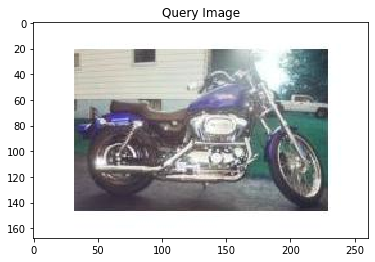

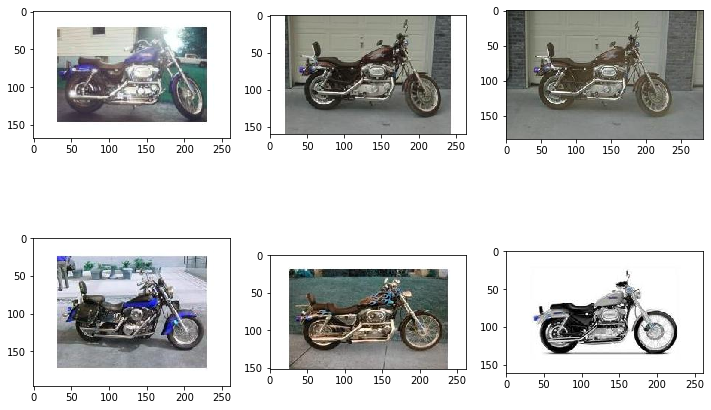

In [193]:
def input_show(data):
  plt.title("Query Image")
  plt.imshow(data)
  
def show_result(data,result):
  fig = plt.figure(figsize=(12,8))
  for i in range(0,6):
    index_result=result[0][i]
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.imread(data[index_result]))
  plt.show()

def main():  
  features=[]
  output=load_data()
  main_model=model()
  #Limiting the data for training
  for i in output[:99]:
    new_img=preprocess_img(i)
    features.append(feature_extraction(new_img,main_model))
  feature_vec = np.array(features)
  result=result_vector_cosine(main_model,feature_vec,preprocess_img(output[100]))
  input_show(cv2.imread(output[100]))
  show_result(output,result)
  

if __name__=='__main__':
  main()